In [ ]:
!git clone https://github.com/QoroQuantum/divi.git


fatal: destination path 'divi' already exists and is not an empty directory.


In [ ]:
!pip install -e ./divi

Obtaining file:///content/divi
  Installing build dependencies ... done
  Checking if build backend supports build_editable ... done
  Getting requirements to build editable ... done
  Preparing editable metadata (pyproject.toml) ... done
  Building editable for qoro-divi (pyproject.toml) ... done
  Created wheel for qoro-divi: filename=qoro_divi-0.4.2-py3-none-any.whl size=10489 sha256=b4fd2401eb827ece09fa3193af387e058357e2baf69f6e0f70d29643d78b8239
  Stored in directory: /tmp/pip-ephem-wheel-cache-szl5r02l/wheels/ad/c5/92/06a109202882b503e0e99bb2892279e8cca96d120dd36de58c
Successfully built qoro-divi
  Attempting uninstall: qoro-divi
    Found existing installation: qoro-divi 0.4.2
    Uninstalling qoro-divi-0.4.2:
      Successfully uninstalled qoro-divi-0.4.2


In [ ]:
# for name, value in vars(vqe).items():
#     print(name, "=", value)

In [ ]:
!pip install pennylane pennylane-qchem
!pip install qoro-divi

  Using cached PennyLane_Qchem-0.23.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached openfermion-1.7.1-py3-none-any.whl.metadata (13 kB)
  Using cached openfermionpsi4-0.5-py3-none-any.whl.metadata (7.6 kB)
  Using cached h5py-3.2.1.tar.gz (368 kB)
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  error: subprocess-exited-with-error
  
  × pip subprocess to install backend dependencies did not run successfully.
  │ exit code: 2
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Installing backend dependencies ... error
error: subprocess-exited-with-error

× pip subprocess to install backend dependencies did not run successfully.
│ exit code: 2
╰─> See above for output.

note: This error originates from a subprocess, and is likely not a problem with pip.


/usr/local/lib/python3.12/dist-packages/pennylane/__init__.py:196: RuntimeWarning: PennyLane is not yet compatible with JAX versions > 0.6.2. You have version 0.7.2 installed. Please downgrade JAX to 0.6.2 to avoid runtime errors using python -m pip install jax~=0.6.0 jaxlib~=0.6.0
  warnings.warn(


N2 BOND LENGTH SWEEP WITH SCIPY OPTIMIZER

BOND LENGTH: 1.00 Å
Hamiltonian: 4 qubits
Exact ground state: -101.751997 Ha

Using scipy.optimize with COBYLA method (divi style)
Iteration | Energy (Ha)
------------------------------
Iteration  10: -101.711910 Ha
Iteration  20: -101.744659 Ha
Iteration  30: -101.750545 Ha
------------------------------
Time taken: 0.38 seconds
Final VQE energy: -101.750545 Ha
Exact ground state: -101.751997 Ha
Error: 0.001452 Ha
Total iterations: 30

BOND LENGTH: 1.10 Å
Hamiltonian: 4 qubits
Exact ground state: -103.425531 Ha

Using scipy.optimize with COBYLA method (divi style)
Iteration | Energy (Ha)
------------------------------
Iteration  10: -103.373192 Ha
Iteration  20: -103.408360 Ha
Iteration  30: -103.423744 Ha
------------------------------
Time taken: 0.37 seconds
Final VQE energy: -103.423744 Ha
Exact ground state: -103.425531 Ha
Error: 0.001788 Ha
Total iterations: 30

BOND LENGTH: 1.20 Å
Hamiltonian: 4 qubits
Exact ground state: -104.645209 H

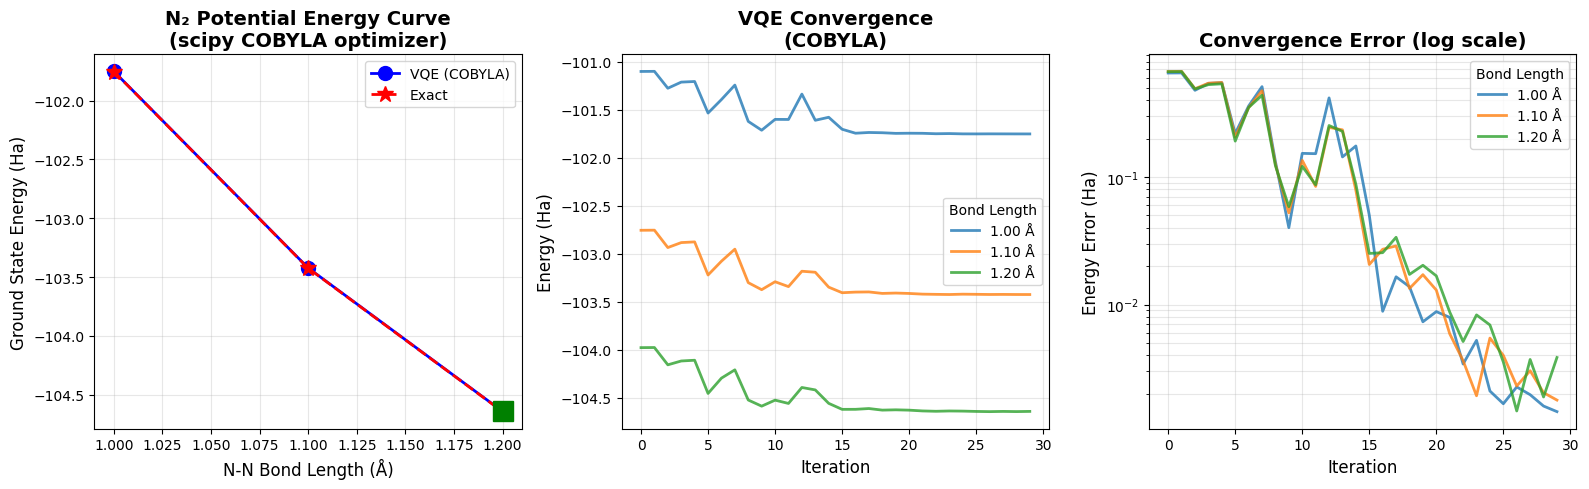


SUMMARY
Total time: 22.84 seconds
Bond lengths scanned: [1.0, 1.1, 1.2]
Optimal bond length: 1.20 Å
Minimum VQE energy: -104.643740 Ha
Minimum exact energy: -104.645209 Ha

Optimizer: scipy.optimize.minimize with COBYLA method
(Same method used by divi ScipyOptimizer)

✓ Complete! N₂ bond length sweep finished


In [ ]:
import time
import numpy as np
import pennylane as qml
from pennylane import numpy as pnp
import matplotlib.pyplot as plt
from scipy.optimize import minimize

from divi.qprog.optimizers import ScipyMethod


if __name__ == "__main__":

    print("="*70)
    print("N2 BOND LENGTH SWEEP WITH SCIPY OPTIMIZER")
    print("="*70)

    # Define bond lengths to sweep (3 values)
    bond_lengths = [1.0, 1.1, 1.2]  # Angstroms

    all_results = []
    all_energies_history = []
    exact_energies = []

    symbols = ["N", "N"]

    total_start = time.time()

    for bond_length in bond_lengths:
        print(f"\n{'='*70}")
        print(f"BOND LENGTH: {bond_length:.2f} Å")
        print(f"{'='*70}")

        # Create coordinates for this bond length
        coordinates = np.array([
            (0.0, 0.0, -bond_length/2),
            (0.0, 0.0,  bond_length/2),
        ])

        # ABSOLUTE MINIMAL HAMILTONIAN
        H, n_qubits = qml.qchem.molecular_hamiltonian(
            symbols,
            coordinates,
            charge=0,
            mult=1,
            basis='sto-3g',
            active_electrons=2,  # Minimal
            active_orbitals=2    # Minimal (4 qubits)
        )

        print(f"Hamiltonian: {n_qubits} qubits")

        # Exact ground state
        H_matrix = qml.matrix(H, wire_order=range(n_qubits))
        exact_gs = np.linalg.eigvalsh(H_matrix)[0]
        exact_energies.append(exact_gs)
        print(f"Exact ground state: {exact_gs:.6f} Ha\n")

        # Direct VQE
        dev = qml.device('default.qubit', wires=n_qubits)

        # Define simple ansatz
        def ansatz(params, wires):
            # Hartree-Fock initial state
            qml.BasisState(np.array([1, 1, 0, 0]), wires=wires)
            # Parameterized gates
            qml.RY(params[0], wires=0)
            qml.RY(params[1], wires=1)
            qml.CNOT(wires=[0, 1])
            qml.RY(params[2], wires=2)
            qml.RY(params[3], wires=3)

        @qml.qnode(dev)
        def cost_fn(params):
            ansatz(params, wires=range(n_qubits))
            return qml.expval(H)

        # VQE optimization using scipy with COBYLA (inspired by divi)
        np.random.seed(42)
        initial_params = np.random.random(4) * 0.1

        # Track energies
        energies = []

        def cost_fn_tracked(params):
            energy = float(cost_fn(params))
            energies.append(energy)
            if len(energies) % 10 == 0:
                print(f"Iteration {len(energies):3d}: {energy:.6f} Ha")
            return energy

        t1 = time.time()
        print("Using scipy.optimize with COBYLA method (divi style)")
        print("Iteration | Energy (Ha)")
        print("-" * 30)

        # Use scipy minimize with COBYLA (same as divi uses)
        result = minimize(
            cost_fn_tracked,
            initial_params,
            method='COBYLA',
            options={'maxiter': 30}
        )

        optimized_params = result.x
        final_energy = float(cost_fn(optimized_params))
        elapsed = time.time() - t1

        print("-" * 30)
        print(f"Time taken: {elapsed:.2f} seconds")
        print(f"Final VQE energy: {final_energy:.6f} Ha")
        print(f"Exact ground state: {exact_gs:.6f} Ha")
        print(f"Error: {abs(final_energy - exact_gs):.6f} Ha")
        print(f"Total iterations: {len(energies)}")

        all_results.append((bond_length, final_energy))
        all_energies_history.append(energies)

    total_time = time.time() - total_start

    # PLOT ALL RESULTS
    print("\n" + "="*70)
    print("PLOTTING BOND LENGTH SWEEP RESULTS")
    print("="*70)

    fig = plt.figure(figsize=(16, 5))

    # Plot 1: Potential Energy Curve
    ax1 = plt.subplot(1, 3, 1)
    bonds = [r[0] for r in all_results]
    vqe_energies = [r[1] for r in all_results]

    ax1.plot(bonds, vqe_energies, 'bo-', linewidth=2, markersize=10, label='VQE (COBYLA)')
    ax1.plot(bonds, exact_energies, 'r*--', linewidth=2, markersize=12, label='Exact')
    ax1.set_xlabel('N-N Bond Length (Å)', fontsize=12)
    ax1.set_ylabel('Ground State Energy (Ha)', fontsize=12)
    ax1.set_title('N₂ Potential Energy Curve\n(scipy COBYLA optimizer)',
                  fontsize=14, fontweight='bold')
    ax1.legend(fontsize=10)
    ax1.grid(True, alpha=0.3)

    # Mark minimum
    min_idx = np.argmin(vqe_energies)
    ax1.plot(bonds[min_idx], vqe_energies[min_idx], 'gs', markersize=15)

    # Plot 2: VQE Convergence for each bond
    ax2 = plt.subplot(1, 3, 2)
    for i, (bond, energy_hist) in enumerate(zip(bonds, all_energies_history)):
        ax2.plot(energy_hist, label=f'{bond:.2f} Å', linewidth=2, alpha=0.8)

    ax2.set_xlabel('Iteration', fontsize=12)
    ax2.set_ylabel('Energy (Ha)', fontsize=12)
    ax2.set_title('VQE Convergence\n(COBYLA)', fontsize=14, fontweight='bold')
    ax2.legend(title='Bond Length', fontsize=10)
    ax2.grid(True, alpha=0.3)

    # Plot 3: Error for each bond
    ax3 = plt.subplot(1, 3, 3)
    for i, (bond, energy_hist) in enumerate(zip(bonds, all_energies_history)):
        errors = [abs(e - exact_energies[i]) for e in energy_hist]
        ax3.semilogy(errors, label=f'{bond:.2f} Å', linewidth=2, alpha=0.8)

    ax3.set_xlabel('Iteration', fontsize=12)
    ax3.set_ylabel('Energy Error (Ha)', fontsize=12)
    ax3.set_title('Convergence Error (log scale)', fontsize=14, fontweight='bold')
    ax3.legend(title='Bond Length', fontsize=10)
    ax3.grid(True, alpha=0.3, which='both')

    plt.tight_layout()
    plt.show()

    # Summary
    print("\n" + "="*70)
    print("SUMMARY")
    print("="*70)
    print(f"Total time: {total_time:.2f} seconds")
    print(f"Bond lengths scanned: {bond_lengths}")
    print(f"Optimal bond length: {bonds[min_idx]:.2f} Å")
    print(f"Minimum VQE energy: {vqe_energies[min_idx]:.6f} Ha")
    print(f"Minimum exact energy: {exact_energies[min_idx]:.6f} Ha")
    print(f"\nOptimizer: scipy.optimize.minimize with COBYLA method")
    print("(Same method used by divi ScipyOptimizer)")
    print("\n✓ Complete! N₂ bond length sweep finished")

    # ----------------------------------------------------------
# 1. Target ground-state energy from VQE calculation
# ----------------------------------------------------------
E_target = exact_energies[min_idx]:.6f

# ----------------------------------------------------------
# 2. Database of catalyst variants (dummy example)
#    In practice: import from materials project, ASE, CSV, etc.
# ----------------------------------------------------------
catalysts = [
    {"name": "Fe(111)", "d_band_center": -2.4, "ads_energy": -0.80},
    {"name": "Ru(0001)", "d_band_center": -1.8, "ads_energy": -1.10},
    {"name": "Co(111)", "d_band_center": -2.0, "ads_energy": -0.95},
    {"name": "Fe-M alloy", "d_band_center": -2.2, "ads_energy": -0.87},
]

# ----------------------------------------------------------
# 3. Simple scoring function:
#    The better the match to the VQE energy, the higher the score.
# ----------------------------------------------------------
def score_catalyst(cat, target_energy, w1=1.0, w2=1.0):
    """
    cat: dict with descriptors
    target_energy: VQE ground-state energy
    w1, w2: weights for descriptors (modifiable)
    """

    # Convert descriptors to a comparable scale:
    # Here we pretend that d-band center and adsorption energy
    # should correlate with the desired molecular energy.
    diff1 = abs(cat["d_band_center"] - (target_energy % 5))      # mock relation
    diff2 = abs(cat["ads_energy"] - (target_energy % 1))         # mock relation

    # Score = inverse error (high is good)
    return 1 / (w1*diff1 + w2*diff2 + 1e-8)

# ----------------------------------------------------------
# 4. Evaluate all catalyst variants
# ----------------------------------------------------------
results = []
for cat in catalysts:
    score = score_catalyst(cat, E_target)
    results.append((cat["name"], score))

# Sort by descending score
results_sorted = sorted(results, key=lambda x: x[1], reverse=True)

# ----------------------------------------------------------
# 5. Print top candidates
# ----------------------------------------------------------
print("Best catalyst matches for target ground-state energy (VQE):")
for name, score in results_sorted:
    print(f"{name}: score = {score:.4f}")